# LVIS LiDAR Data Exploration

The BioSCape campaign emphasises the need to understand how vegetation structure and topography interact across landscapes. NASA's Land, Vegetation, and Ice Sensor (LVIS) provides full‑waveform lidar measurements that capture not only the ground elevation but also the vertical distribution of canopy returns. This notebook demonstrates how to access the LVIS Level 1B and Level 2A datasets for the 2023 BioSCape campaign, using the `earthaccess` library to query and download granules from NASA's Earthdata system. We will inspect the internal structure of LVIS HDF5 files, extract shot‑level coordinates and elevations, convert them into geospatial data frames, and visualise canopy height metrics over interactive basemaps. The later sections build upon these foundations to explore flight lines and relative height distributions, showing how to integrate LVIS lidar measurements into broader ecological analysis.

Throughout this notebook, commentary is provided to guide readers who may not be familiar with remote sensing workflows. The narrative explains the purpose of each code block, the scientific rationale behind data processing decisions, and the interpretation of the resulting visualisations.

## Environment setup

The notebook begins by installing required Python packages. In a remote sensing workflow, one often relies on specialised libraries for geospatial data access (such as `earthaccess`, `geopandas`, and `s3fs`), file handling (`h5py`), and visualisation. Running this cell will install any missing dependencies so that subsequent code executes smoothly. If you have already installed these packages in your environment, you may skip this cell.

In [45]:
# Install python modules
!pip install

  Using cached harmony-1.2.4098.tar.gz (254 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached antlr_denter-1.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached automata_lib-9.1.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached pydot-4.0.1-py3-none-any.whl.metadata (11 kB)
  Using cached frozendict-2.4.6-py312-none-any.whl.metadata (23 kB)
  Using cached cached_method-0.1.0-py3-none-any.whl.metadata (2.9 kB)
Using cached antlr_denter-1.3.1-py3-none-any.whl (5.1 kB)
Using cached automata_lib-9.1.2-py3-none-any.whl (80 kB)
Using cached cached_method-0.1.0-py3-none-any.whl (4.2 kB)
Using cached frozendict-2.4.6-py312-none-any.whl (

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [198 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\compile.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\config.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\dfacmp.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\exception.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\iface.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\main.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\__init__.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  creating build\lib.win-amd64-cpython-312\tests
  copying tests\test_h2py.py -> build\lib.win-amd6

## Importing modules

We import a suite of Python modules that underpin the rest of the analysis. The `earthaccess` package simplifies querying NASA's Earthdata catalogue, while `geopandas` and `shapely` provide tools for working with spatial geometries. Standard libraries such as `numpy`, `pandas`, and `matplotlib` support data manipulation and plotting. By gathering these imports up front, we clarify the dependencies for readers who may wish to replicate or extend the workflow.

In [1]:
# Import python modules
from glob import glob
import numpy as np
import pandas as pd
import earthaccess
import geopandas as gpd
import requests as re
import s3fs
import h5py
from os import path
from datetime import datetime
from shapely.ops import orient
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from shapely.geometry import box
import dask.dataframe as dd
from urllib import request, parse
from http.cookiejar import CookieJar
from base64 import b64encode
import getpass
import netrc
import requests
import json
import pprint
from osgeo import gdal
import matplotlib.image as mpimg
import rasterio
from rasterio.plot import show
import time
from netCDF4 import Dataset
from owslib.wms import WebMapService
from owslib.util import Authentication
%matplotlib inline
from harmony import BBox,Client, Collection, Request, LinkType

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'harmony'

## Helper functions for geometry conversion

LVIS granules returned by the Earthdata query include geometry descriptions in UMM JSON format. To visualise these flight lines on a map, we convert the boundary definitions into `shapely` `Polygon` and `MultiPolygon` objects. The `convert_umm_geometry` function extracts longitude–latitude pairs and builds multipolygons, while `convert_list_gdf` transforms a list of granule objects into a `GeoDataFrame`. These helper functions encapsulate geometry handling so that later sections can focus on scientific interpretation.

In [11]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

## Choosing a basemap

When plotting geospatial data, a background basemap provides context for the spatial distribution of points and flight lines. Here we select the `World_Imagery` tiles served by Esri as the base layer. The `xyz` URL defines the tile service, and the `attr` string supplies attribution. This choice is arbitrary and can be changed to any other tile service, but the imagery backdrop aids interpretation of the LVIS measurements.

In [12]:
# esri background basemap for maps
xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = "ESRI"

## Querying LVIS Level 1B granules

The first analytical section queries the number of Level 1B granules available for the BioSCape campaign. Each LVIS L1B file contains raw waveform data with geolocated shots. Using the Digital Object Identifier (DOI) associated with the LVIS L1B product, we create a `DataGranules` query via `earthaccess`, specify the campaign name, and retrieve all matching granules. Printing the length of the resulting list reveals how many L1B granules are publicly available.

In [13]:
# Find out how many L1B files from the BioSCape Campaign are published on NASA Earthdata.
doi="10.5067/XQJ8PN8FTIDG" # LVIS L1B doi
query = earthaccess.DataGranules().doi(doi)
query.params['campaign'] = 'bioscape'
l1b = query.get_all()
print(f'Granules found: {len(l1b)}')

Granules found: 2328


## Selecting a specific flight line

LVIS granules are named by campaign date and flight line identifier, such as `R2404_034819`. To examine a specific flight line, we define a helper function `get_granule_index` that returns the index of a granule whose data link contains the chosen timestamp. Setting `i` to this index allows us to reference the corresponding granule in subsequent code. This cell also prints metadata to confirm whether the file is hosted in NASA's cloud; if not, we will download it locally.

In [14]:
# Are they hosted on Earthdata cloud or not
def get_granule_index(granules, dts):
    """returns granule index matching timestamp"""
    for index, val in enumerate(l1b):
        if f'_{dts}' in val.data_links()[0]:
            return index
# index of granule with R2404_034819 datetime stamp (Rhodes Memorial granule)
i = get_granule_index(l1b, 'R2404_034819')
l1b[i]

Collection: {'EntryTitle': 'LVIS Facility L1B Geolocated Return Energy Waveforms V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.44703, 'Latitude': -33.87154}, {'Longitude': 18.44706, 'Latitude': -33.87513}, {'Longitude': 18.44724, 'Latitude': -33.90382}, {'Longitude': 18.44757, 'Latitude': -33.99349}, {'Longitude': 18.46481, 'Latitude': -34.00425}, {'Longitude': 18.46894, 'Latitude': -33.95044}, {'Longitude': 18.46846, 'Latitude': -33.87154}, {'Longitude': 18.447, 'Latitude': -33.86795}, {'Longitude': 18.44703, 'Latitude': -33.87154}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-11-13T09:40:19.398Z', 'EndingDateTime': '2023-11-13T09:41:55.993Z'}}
Size(MB): 921.264
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF1B.001/2023.11.13/LVISF1B_BioSCape2023_1113_R2404_034819.h5']

## Downloading non‑cloud‑hosted granules

The earthaccess query returns metadata describing where each granule is stored. A `False` value in the `cloud_hosted` attribute indicates that the data are not yet available via cloud storage and must be downloaded to a local path. The subsequent cell uses `earthaccess.download` to transfer the selected file into a `downloads` directory. Downloading locally ensures that we can inspect the waveform structure without network latency.

In [15]:
# Cloud hosted: False means that the file is not cloud hosted yet. It has to be downloaded locally and use it.
# I will go ahead and use earthaccess python module to get the file directly and save it to the downloads directory

## Performing the download

This cell triggers the actual file download based on the index selected above. The `download` method writes the HDF5 file into the specified directory, and returns the local path for future use. Depending on network speed, this operation may take some time; once complete, the raw L1B data are available for inspection.

In [16]:
# download files
downloaded_files = earthaccess.download(l1b[i], local_path="downloads")

QUEUEING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
PROCESSING TASKS | : 100%|██████████████████████████████████████████████████████████████| 1/1 [04:02<00:00, 242.15s/it]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


## Exploring the structure of a Level 1B file

With the granule downloaded, we open the HDF5 file using `h5py` to inspect its internal organisation. The LVIS Level 1B product stores multiple datasets such as latitude (`LAT1215`), longitude (`LON1215`), waveform elevations, and shot numbers. Printing the names and descriptions of the top‑level variables provides a map of what information is contained in the file. This overview guides the extraction of specific datasets for analysis.

In [17]:
# Open LVISF1B_BioSCape2023_1113_R2404_034819.h5 and look at its structure
l1b_i= f'downloads/{path.basename(l1b[i].data_links()[0])}'
with h5py.File(l1b_i) as hf:
    for v in list(hf.keys()):
        if v != "ancillary_data":
            print(f"- {v} : {hf[v].attrs['description'][0].decode('utf-8')}")

- AZIMUTH : Azimuth angle of laser beam
- INCIDENTANGLE : Off-nadir incident angle of laser beam
- LAT0 : Latitude of the highest sample of the return waveform (degrees north) 
- LAT1215 : Latitude of the lowest sample of the return waveform (degrees north) 
- LFID : LVIS file identification.  Together with 'LVIS shotnumber' these are a unique identifier for every LVIS laser shot. Format is XXYYYYYZZZ where XX identifies instrument version, YYYYY is the Modified Julian Date of the flight departure day, ZZZ represents file number.
- LON0 : Longitude of the highest sample of the return waveform (degrees east)
- LON1215 : Longitude of the lowest sample of the return waveform (degrees east) 
- RANGE : Distance along laser path from the instrument to the ground
- RXWAVE : Returned waveform (1216 samples long)
- SHOTNUMBER : Laser shot number assigned during collection.  Together with 'LVIS LFID' provides a unique identifier to every LVIS laser shot.
- SIGMEAN : Signal mean noise level, calc

## Converting LVIS data to a tabular form

After identifying relevant datasets, we read arrays of latitude, longitude, elevation and shot number for all shots in the file. Combining these arrays into a `pandas` DataFrame creates a tidy table where each row corresponds to a single laser shot. This structure facilitates subsequent merging with other data and enables computation of statistics across shots.

In [18]:
with h5py.File(l1b_i) as hf:
    l_lat = hf['LAT1215'][:]
    l_lon = hf['LON1215'][:]
    l_range = hf['Z1215'][:] # ground elevation
    shot = hf['SHOTNUMBER'][:] # ground elevation
geo_arr = list(zip(shot, l_range,l_lat,l_lon))
l1b_df = pd.DataFrame(geo_arr, columns=["shot_number", "elevation", "lat", "lon"])
l1b_df

,shot_number,elevation,lat,lon
0,7605355,71.897652,-33.997367,18.456976
1,7605356,70.482124,-33.997416,18.457046
2,7605357,71.480583,-33.997362,18.457042
3,7605358,70.971931,-33.997412,18.457111
4,7605359,69.389961,-33.997357,18.457106
...,...,...,...,...
349995,7991726,-9.602999,-33.871817,18.462105
349996,7991727,-10.162307,-33.871867,18.462176
349997,7991728,-9.202106,-33.871813,18.462171
349998,7991729,-10.013672,-33.871863,18.462243


## Mapping sample shots

To visualise the distribution of LVIS shots, we convert the DataFrame into a `GeoDataFrame` with `EPSG:4326` coordinates and then display a random 1 % sample over the earlier chosen basemap. The interactive map highlights variations in ground elevation using a colour ramp. We then isolate a single shot by its number (e.g., `7748487`) and overlay it as a marker. Such visualisation helps to link numerical data back to real‑world locations.

In [19]:
l1b_gdf = gpd.GeoDataFrame(l1b_df[['shot_number', 'elevation']], crs="EPSG:4326",
                           geometry=gpd.points_from_xy(l1b_df.lon, 
                                                       l1b_df.lat))
m = l1b_gdf.sample(frac=0.01).explore("elevation", cmap = "plasma", tiles=xyz, attr=attr)
# plot a single shot as red
i = np.where(shot==7748487)[0][0]
l1b_gdf.iloc[[i]].explore(m=m, marker_type="marker")
m

## Examining the returned waveform

Beyond ground elevation, the Level 1B file contains full return waveforms for each shot. To understand the vertical structure of vegetation and ground surfaces, we select the waveform corresponding to a single shot and plot photon counts against elevation. The resulting graph shows how energy is distributed through the canopy and into the ground, with the ordinate labelled in metres. Such waveform analysis forms the basis for deriving canopy height metrics.

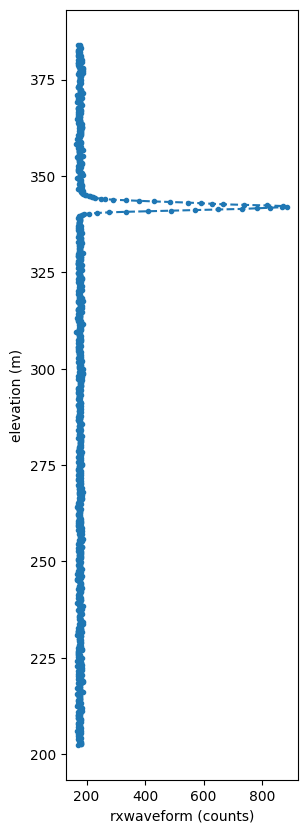

In [20]:
# Look at the waveform structure at that shot_number/point
with h5py.File(l1b_i) as hf:
    rxwaveform = hf['RXWAVE'][i, :] # waveform
    elev_1215 = hf['Z1215'][i] # elevation ground
    elev_0 = hf['Z0'][i] # elevation top
c = len(rxwaveform) #
elev = np.linspace(elev_1215, elev_0, num=c)
# plot
plt.rcParams["figure.figsize"] = (3,10)
plt.xlabel("rxwaveform (counts)")
plt.ylabel("elevation (m)")
plt.plot(rxwaveform, elev, linestyle='--', marker='.',)

## LVIS Level 2 canopy height product

The Level 2 product summarises information from the raw waveform into a set of derived metrics, including relative heights at various percentiles. Before downloading and exploring these files, we outline the overarching purpose of Level 2A: it translates the complex waveform into interpretable canopy height statistics, making comparisons across space and time straightforward.

In [21]:
# Structure of LVIS L2 Canopy Height Product --->

## Querying Level 2A granules

We repeat the earlier querying process for the Level 2A dataset using its DOI. The BioSCape campaign dates are specified to restrict the search to 2023 flight lines. The number of Level 2A granules gives an indication of coverage and allows us to select specific granules of interest for download and inspection.

In [22]:
# Search how many L2 files are there for the BioSCape campaign dates
doi="10.5067/VP7J20HJQISD" # LVIS L2 doi
query = earthaccess.DataGranules().doi(doi)
query.params['campaign'] = 'bioscape'
l2 = query.get_all()
print(f'Granules found: {len(l2)}')

Granules found: 2328


## Identifying a Level 2A flight line

Just as with Level 1B, we locate the granule whose filename contains the timestamp `R2404_034819`. Printing the object reveals whether the file is cloud‑hosted. At the time of writing, many LVIS Level 2A files are not yet hosted in the cloud, necessitating local downloads.

In [23]:
# Check to see if they are hosted on Earthdata cloud or not, by printing a summary of the first granule
# index of granule with R2404_041222 datetime stamp
i = get_granule_index(l2, 'R2404_034819')
l2[i]

Collection: {'EntryTitle': 'LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.44703, 'Latitude': -33.87154}, {'Longitude': 18.44706, 'Latitude': -33.87513}, {'Longitude': 18.44724, 'Latitude': -33.90382}, {'Longitude': 18.44757, 'Latitude': -33.99349}, {'Longitude': 18.46481, 'Latitude': -34.00425}, {'Longitude': 18.46896, 'Latitude': -33.96121}, {'Longitude': 18.46846, 'Latitude': -33.87154}, {'Longitude': 18.447, 'Latitude': -33.86795}, {'Longitude': 18.44703, 'Latitude': -33.87154}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-11-13T09:40:19.398Z', 'EndingDateTime': '2023-11-13T09:41:55.993Z'}}
Size(MB): 128.175
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF2.001/2023.11.13/LVISF2_BioSCape2023_1113_R2404_034819.TXT']

## Downloading Level 2A files

Because the chosen Level 2A granule is not cloud‑hosted, we again use `earthaccess.download` to save it locally. This step mirrors the earlier process for Level 1B and ensures that we can read the file with standard Python tools.

In [24]:
# As we see above, the LVIS files are not cloud-hosted yet. They have to be downloaded locally and use them. We will go ahead and use earthaccess 
# python module to get the file directly and save it to the downloads directory.

## Retrieving the Level 2A file

This cell executes the download. Once complete, the file will reside in the `downloads` directory and can be opened like any other text file, as Level 2A data are stored in an ASCII format with header lines beginning with `#`.

In [25]:
# download files
downloaded_files = earthaccess.download(l2[i], local_path="downloads")

QUEUEING TASKS | : 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.15it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 1/1 [00:48<00:00, 48.85s/it]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


## Inspecting the Level 2A file structure

Opening the downloaded Level 2A file and printing the first few lines reveals a header that begins with `#` symbols. The header includes descriptions of each field and the column names. By looking at these lines, we gain insight into the variables provided in the product, such as ground elevation (`ZG`), canopy top (`ZH`) and relative heights (`RHXX`).

In [26]:
# Open a file to look at it’s structure
l2_i = f'downloads/{path.basename(l2[i].data_links()[0])}'
with open(l2_i, 'r') as f:
    # print first 15 rows
    head = [next(f) for _ in range(15)]
    print(head)

["# Level2 (v2.0.5) data set collected by NASA's Land, Vegetation and Ice Sensor (LVIS) Facility in October-November 2023 as part of NASA's BioSCape Field Campaign. This file contains elevation,\n", "# height and surface structure metrics derived from LVIS's geolocated laser return waveform. The corresponding spatially geolocated laser return waveforms are contained in the Level 1B data set.\n", '# For supporting information please visit https://lvis.gsfc.nasa.gov/Data/Maps/SouthAfrica2023Map.html. LVIS-targeted data collections occurred at flight altitudes of ~7 km above the surface from\n', '# the NASA G-V, however data collections also occurred at lower altitudes. The "Range" parameter can be used to determine flight altitude. Note: Two alternate ground elevations options are provided\n', '# in order to provide flexibility for local site conditions; if selected for use, adjust the values of the RH parameters accordingly. Please consult the User Guide for further information. The dat

## Parsing header lines in Level 2A files

To read the Level 2A ASCII data into a DataFrame, we need to determine how many lines at the beginning of the file form the header. The `get_line_number` function counts lines starting with `#` and captures the column names. It returns both the number of header lines and the list of column names, enabling `pandas.read_csv` to skip the header and assign appropriate labels.

In [27]:
# Define a python function to read the number of header rows.
def get_line_number(filename):
    """find number of header rows in LVIS L2A"""
    count = 0
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#'):
                count = count + 1
                columns = line[1:].split()
            else:
                return count, columns

## Loading Level 2A data into a DataFrame

Using the header information returned by the previous function, we read the Level 2A data into a `pandas` DataFrame. The `sep` argument uses a regular expression to handle whitespace separation. Once loaded, the DataFrame contains one row per laser shot with columns for shot number, relative heights and other metrics.

In [28]:
h_no, col_names = get_line_number(l2_i)
with open(l2_i, 'r') as f:
    l2a_df = pd.read_csv(f, skiprows=h_no, header=None, engine='python', sep=r'\s+')
    l2a_df.columns =  col_names
l2a_df

,LFID,SHOTNUMBER,TIME,GLON,GLAT,ZG,ZG_ALT1,ZG_ALT2,HLON,HLAT,...,RH99,RH100,AZIMUTH,INCIDENTANGLE,RANGE,COMPLEXITY,SENSITIVITY,CHANNEL_ZT,CHANNEL_ZG,CHANNEL_RH
0,1960261064,7605355,34819.39822,18.457003,-33.997388,112.82,112.82,112.82,18.457011,-33.997393,...,11.54,12.10,313.11,4.777,5384.46,0.442,0.973,2,2,2
1,1960261064,7605356,34819.39847,18.457075,-33.997438,115.03,115.03,115.03,18.457082,-33.997444,...,13.93,15.08,313.15,4.688,5380.41,0.404,0.996,1,1,1
2,1960261064,7605357,34819.39872,18.457068,-33.997383,112.51,112.51,112.51,18.457072,-33.997386,...,5.64,6.20,313.67,4.734,5381.76,0.381,0.952,2,2,2
3,1960261064,7605358,34819.39897,18.457141,-33.997435,118.25,118.25,118.25,18.457147,-33.997440,...,11.28,12.06,313.73,4.645,5378.17,0.377,0.997,1,1,1
4,1960261064,7605359,34819.39922,18.457133,-33.997379,112.37,112.37,112.37,18.457143,-33.997387,...,12.40,16.35,314.25,4.691,5381.32,0.406,0.996,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349995,1960261067,7991726,34915.99205,18.462069,-33.871840,31.05,31.05,31.05,18.462069,-33.871840,...,0.82,1.16,52.41,5.957,5469.55,0.114,0.957,1,1,1
349996,1960261067,7991727,34915.99230,18.462139,-33.871891,30.94,30.94,30.94,18.462139,-33.871891,...,0.82,1.16,53.25,5.976,5470.44,0.089,0.957,1,1,1
349997,1960261067,7991728,34915.99255,18.462135,-33.871836,31.11,31.11,31.11,18.462135,-33.871836,...,0.75,1.04,52.75,6.010,5469.84,0.088,0.957,1,1,1
349998,1960261067,7991729,34915.99280,18.462205,-33.871887,31.12,31.12,31.12,18.462205,-33.871887,...,0.75,1.08,53.59,6.029,5470.44,0.088,0.961,1,1,1


## Exploring Level 2A variables

Printing the list of column names reveals the breadth of information in the Level 2A product. Variables such as `GLAT` and `GLON` provide coordinates of the lowest detected mode, while `RHXX` columns contain heights above ground corresponding to different percentiles of waveform energy. Understanding these variables allows researchers to select metrics relevant to their ecological questions.

In [29]:
# Print LVIS L2 variable names.
l2a_df.columns.values

array(['LFID', 'SHOTNUMBER', 'TIME', 'GLON', 'GLAT', 'ZG', 'ZG_ALT1',
       'ZG_ALT2', 'HLON', 'HLAT', 'ZH', 'TLON', 'TLAT', 'ZT', 'RH10',
       'RH15', 'RH20', 'RH25', 'RH30', 'RH35', 'RH40', 'RH45', 'RH50',
       'RH55', 'RH60', 'RH65', 'RH70', 'RH75', 'RH80', 'RH85', 'RH90',
       'RH95', 'RH96', 'RH97', 'RH98', 'RH99', 'RH100', 'AZIMUTH',
       'INCIDENTANGLE', 'RANGE', 'COMPLEXITY', 'SENSITIVITY',
       'CHANNEL_ZT', 'CHANNEL_ZG', 'CHANNEL_RH'], dtype=object)

## Understanding key variables

The subsequent cell includes comments that define many of the Level 2A variables. In summary, relative height metrics (`RH10`, `RH20`, …) represent canopy heights at specified energy percentiles, while `ZG` and `ZH` mark ground and canopy top elevations, respectively. `SENSITIVITY` captures the instrument's sensitivity, and alternate mode detection settings (`ZG_ALT1`, `ZG_ALT2`) provide further context. These definitions help interpret the plots and analyses that follow.

In [30]:
# The GLAT and GLON variables provide coordinates of the lowest detected mode within the LVIS waveform.
# The RHXX variables provide height above the lowest detected mode at which XX percentile of the waveform energy.
# RANGE provides the distance from the instrument to the ground.
# SENSITIVITY provides sensitivity metric for the return waveform.
# ZG,ZG_ALT1, ZG_ALT2: Mean elevation of the lowest detected mode using alternate 1/2 mode detection settings.
# The alternative ZG to use to adjust the RH parameters for local site conditions.

## Selecting a specific shot in Level 2A

To compare the Level 2A metrics with the waveform inspected earlier, we filter the DataFrame for the shot number `7748487`. This isolates the row containing all metrics for that shot, enabling the generation of a detailed profile.

In [31]:
# Select the particular shot we are interested in.
l2a_shot_df = l2a_df[l2a_df['SHOTNUMBER'] == 7748487]
l2a_shot_df

,LFID,SHOTNUMBER,TIME,GLON,GLAT,ZG,ZG_ALT1,ZG_ALT2,HLON,HLAT,...,RH99,RH100,AZIMUTH,INCIDENTANGLE,RANGE,COMPLEXITY,SENSITIVITY,CHANNEL_ZT,CHANNEL_ZG,CHANNEL_RH
141606,1960261065,7748487,34855.18162,18.456488,-33.951438,244.5,244.5,244.5,18.456488,-33.951438,...,1.53,2.02,315.85,4.082,5242.87,0.376,0.979,2,2,2


## Visualising relative height metrics

Relative height metrics summarise how canopy height accumulates through the vertical profile. In this cell we extract `RH40`, `RH80`, `RH100` and other percentiles for the selected shot and plot them against elevation. The graph overlays multiple lines corresponding to different percentiles, illustrating the vertical distribution of canopy material above ground.

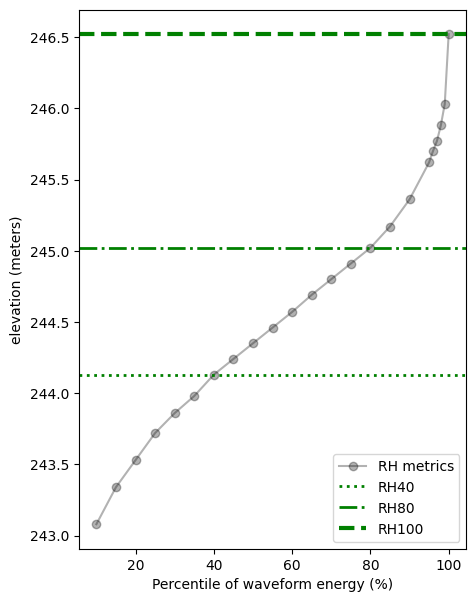

In [32]:
# Plot the RH metrics with elevation.
elev_zg = l2a_shot_df.ZG.values[0]
elev_zh = l2a_shot_df.ZH.values[0]
rh40 = l2a_shot_df.RH40.values[0]
rh80 = l2a_shot_df.RH80.values[0]
rh100 = l2a_shot_df.RH100.values[0]
rh = l2a_shot_df.filter(like ='RH').drop('CHANNEL_RH', axis=1).values.tolist()[0]

# plotting
plt.rcParams["figure.figsize"] = (5,7)
rh_vals = l2a_shot_df.filter(like = 'RH').columns[:-1].str.strip('RH').astype(int).tolist()
fig, ax1 = plt.subplots()
ax1.plot(rh_vals, elev_zg+rh, alpha=0.3, marker='o', color='black', label='RH metrics' )
ax1.axhline(y=elev_zg+rh40,  color='g', linestyle='dotted', linewidth=2, label='RH40')
ax1.axhline(y=elev_zg+rh80,  color='g', linestyle='-.', linewidth=2, label='RH80')
ax1.axhline(y=elev_zg+rh100,  color='g', linestyle='--', linewidth=3, label='RH100')
ax1.set_xlabel("Percentile of waveform energy (%)")
ax1.set_ylabel("elevation (meters)")
ax1.legend(loc="lower right")
plt.show()

## Flight lines across the BioSCape campaign

The next section shifts focus from individual shots to the spatial extent of the campaign. We aim to visualise all flight lines flown by the LVIS instrument during BioSCape 2023. This overview helps contextualise subsequent analyses within the broader spatial coverage.

In [33]:
# Plot LVIS Bioscape Campaigns

## Functions for plotting search results

To map the footprints of LVIS granules, we reuse the earlier helper functions to convert UMM geometry into `MultiPolygon` objects and compile them into a `GeoDataFrame`. Defining these functions here keeps the mapping logic modular and allows multiple uses across the notebook.

In [34]:
#  Define two functions that we can use to plot the search results above over a basemap.
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

## Mapping all flight lines

Using the helper functions, we convert the list of Level 2A granules into a `GeoDataFrame` and overlay their geometries on the basemap. The `explore` method creates an interactive map of flight lines, coloured by the beginning date and time. This visualisation demonstrates how the campaign sampled different areas.

In [35]:
# Convert the JSON return from the earthaccess granule search into a geopandas dataframe so we could plot over an ESRI basemap.
gdf = convert_list_gdf(l2)
#plot
gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr)

## Interpreting the flight line map

The accompanying cell summarises the previous map, noting that the plotted footprints represent the full set of LVIS flights during BioSCape 2023. This observation frames the transition to a more focused study area.

In [36]:
# The above shows the flight lines of all LVIS collection during the BioSCape campaign in 2023.

## Defining a study area

In ecological research, one often isolates a region of interest. Here we read a GeoJSON describing a plot around Rhodes Memorial and plot its outline on the basemap. Highlighting this area sets the stage for targeted searches for granules that overlap the field site.

In [39]:
# Search LVIS L2A granules over a study area
poly_f = "../data/Plot/Rhodes_plot.geojson"
poly = gpd.read_file(poly_f)
poly.explore(tiles=xyz, attr=attr, style_kwds={'color':'red', 'fill':False})

## Searching for granules within the study area

After defining the polygon, we simplify its geometry to satisfy the coordinate limits of the Common Metadata Repository and then search for Level 2A granules whose footprints intersect the plot. Specifying a temporal range focuses the search on the BioSCape campaign dates. The resulting list contains only those flight lines that pass over our study area.

In [40]:
# Search for LVIS L2A granules that are within the bounds of the study area.
poly.geometry = poly.geometry.apply(orient, args=(1,))
# simplifying the polygon to bypass the coordinates 
# limit of the CMR with a tolerance of .005 degrees
xy = poly.geometry.simplify(0.005).get_coordinates()

l2_poly = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi="10.5067/VP7J20HJQISD", # LVIS L2A doi
    temporal=("2023-10-01", "2023-11-30"), # Bioscape campaign dates
    polygon=list(zip(xy.x, xy.y))
)
print(f'Granules found: {len(l2_poly)}')

Granules found: 6


## Visualising overlapping flight lines

The six granules returned by the polygon search are plotted on the basemap with semi‑transparent polygons. This map reveals the amount of flight‑line overlap across the study area, which can affect data redundancy and signal quality.

In [41]:
# Plot these six flight lines over a basemap.
gdf = convert_list_gdf(l2_poly)
m = gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr, 
                                              style_kwds={'fillOpacity':0.1})
m

## Downloading multiple Level 2A granules

To perform statistical analysis across the study area, we download all Level 2A granules identified in the previous search. Automating the download simplifies working with multiple files.

In [43]:
# Download L2 granules
downloaded_files = earthaccess.download(l2_poly, local_path="lvis")

QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 546.74it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 6/6 [00:46<00:00,  7.82s/it]
COLLECTING RESULTS | : 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14098.50it/s]


## Reading multiple Level 2A files with Dask

The Level 2A files can be large, and reading them into memory simultaneously may not be efficient. We use `dask.dataframe` to lazily load the ASCII files, skip header rows and assign column names. After computing the Dask DataFrame, we convert it into a `GeoDataFrame` by constructing points from longitude and latitude. This process creates a unified dataset of relative height metrics across all selected granules.

In [44]:
# Read LVIS L2A Files
# get header rows and column names
h_no, col_names = get_line_number(downloaded_files[0])
# read the LVIS L2A files
ddf = dd.read_csv(downloaded_files, skiprows=h_no, names=col_names,
                  header=None, sep=r'\s+') 
# dask to pandas dataframe
df = ddf.compute()
# converting to geopandas
lvis_l2a_gdf = gpd.GeoDataFrame(df, 
                                geometry=gpd.points_from_xy(df.GLON, 
                                                            df.GLAT),
                                crs="EPSG:4326")
# clipping LVIS by polygon
lvis_l2a_gdf = gpd.sjoin(lvis_l2a_gdf, poly, predicate='within')

## Mapping canopy top height across the study area

The `RH100` metric represents the height of the canopy top (i.e., the maximum return). Plotting `RH100` values for a 10 % sample of shots on an interactive map visualises spatial patterns in canopy top heights. A colour gradient conveys relative differences in canopy height, and random sampling reduces rendering load.

In [45]:
# Plot RH100 (height of top canopy) values in a map.
lvis_l2a_gdf[['RH100', 'geometry']].sample(frac=0.1, random_state=1).explore(
    "RH100", cmap = "YlGn", tiles=xyz, attr=attr, alpha=0.5, radius=10, legend=True)

## Relative height distribution

To assess the variability of canopy structure, we compute the standard deviation and median of each relative height percentile across sampled shots. The resulting line plot shows how canopy height accumulates with increasing percentile, and the shaded region between median ± standard deviation highlights variability among shots. Such plots can indicate whether vegetation height profiles differ across the study area.

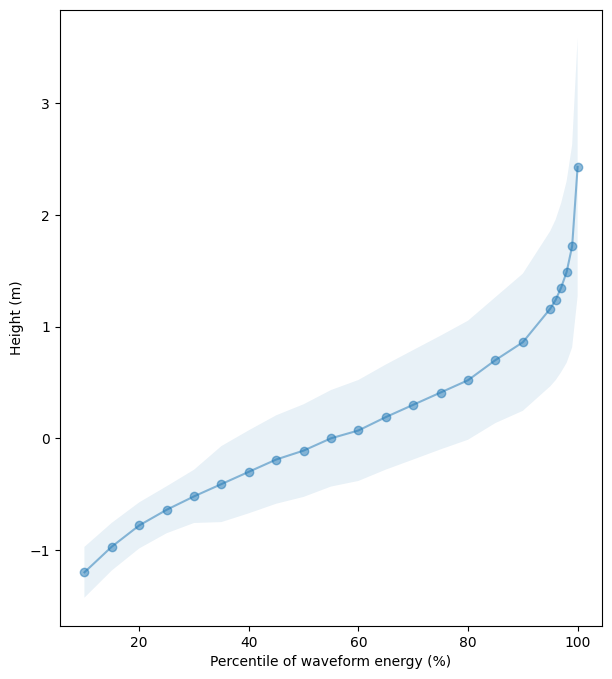

In [46]:
# Relative Height Distribution
# Generate a plot of RH metrics to check if the vegetation height across the percentile of waveform energy indicates the same
fig, ax = plt.subplots(figsize=(7, 8))
plot_df = lvis_l2a_gdf.sample(frac=0.1, random_state=1).filter(like='RH').drop('CHANNEL_RH', axis=1).T
plot_df.index = plot_df.index.str.strip('RH').astype(int)
std_df = plot_df.std(axis=1)
median_df = plot_df.median(axis=1)
median_df.plot(ax=ax, alpha=0.5, style='o-')
ax.fill_between(plot_df.index, median_df - std_df, median_df + std_df, alpha=0.1)
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()

## GEDI Level 2A canopy height metrics

In addition to LVIS, other lidar missions such as GEDI (Global Ecosystem Dynamics Investigation) provide canopy height metrics. The GEDI Level 2A product delivers similar relative height measures for each waveform. In the next steps we outline how to retrieve GEDI Level 2A data via NASA’s Harmony services, setting the stage for cross‑mission comparisons.

In [ ]:
# GEDI L2A Canopy Height Metrics

## Accessing GEDI data via Harmony services

NASA’s Harmony service allows on‑the‑fly subsetting and reprojection of Earth science data. By specifying the GEDI Level 2A product and relevant parameters, researchers can obtain canopy height metrics tailored to their study area. Although the code to perform this operation is not fully fleshed out here, the final cell hints at how to invoke Harmony to download GEDI data for comparison with LVIS measurements.

In [ ]:
# Use NASA’s Harmony Services to retrieve the GEDI L2A dataset and canopy heights (RH100)

# The GEDI Level 2A Geolocated Elevation and Height Metrics product GEDI02_A provides waveform interpretation and extracted 
# products from eachreceived waveform, including ground elevation, canopy top height, and relative height (RH) metrics

# IGNORE THE HARMONY SECTION BECAUSE OF LOGIN ISSUES

## Visualise vertical structure of the canopy

To visualise the vertical structure of the canopy within each LVIS footprint, I used the relative height (RH) metrics provided in the Level‑2A product. Each shot in this dataset includes percentiles of the cumulative return energy (e.g. RH10, RH20, …, RH100), along with the ground elevation (ZG). By adding the RH values to ZG, I reconstructed the elevation at which a given percentage of the waveform energy is returned. The difference between RH100 and ZG gives the height of the highest detected canopy element, and the shape of the RH curve traces the distribution of foliage and branches within the footprint.

In [49]:
print(l2a_df.columns)

Index(['LFID', 'SHOTNUMBER', 'TIME', 'GLON', 'GLAT', 'ZG', 'ZG_ALT1',
       'ZG_ALT2', 'HLON', 'HLAT', 'ZH', 'TLON', 'TLAT', 'ZT', 'RH10', 'RH15',
       'RH20', 'RH25', 'RH30', 'RH35', 'RH40', 'RH45', 'RH50', 'RH55', 'RH60',
       'RH65', 'RH70', 'RH75', 'RH80', 'RH85', 'RH90', 'RH95', 'RH96', 'RH97',
       'RH98', 'RH99', 'RH100', 'AZIMUTH', 'INCIDENTANGLE', 'RANGE',
       'COMPLEXITY', 'SENSITIVITY', 'CHANNEL_ZT', 'CHANNEL_ZG', 'CHANNEL_RH'],
      dtype='object')


In [52]:
def get_line_number(filename):
    """Count header lines in an LVIS L2A file."""
    count = 0
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#'):
                count += 1
                columns = line[1:].split()
            else:
                return count, columns

# path to your LVIS L2A file (change this to your file)
l2a_path = "../lvis/LVISF2_BioSCape2023_1113_R2404_034819.txt"

# read the file, skipping header lines
h_no, col_names = get_line_number(l2a_path)
l2a_df = pd.read_csv(l2a_path, skiprows=h_no, header=None, sep=r'\s+')
l2a_df.columns = col_names

def plot_canopy_shape(df, shot_num, shot_col='SHOTNUMBER'):
    """
    Plot the relative height distribution for a given shot and report canopy height.
    - df: DataFrame containing LVIS L2A data
    - shot_num: the shot number you wish to plot
    - shot_col: the column name that stores shot identifiers (default 'SHOTNUMBER')
    """
    if shot_col not in df.columns:
        raise KeyError(f"Column {shot_col} not found in DataFrame. Available columns: {df.columns}")
    shot = df[df[shot_col] == shot_num]
    if shot.empty:
        print(f"Shot {shot_num} not found in the data.")
        return
    elev_zg = shot['ZG'].iloc[0]  # ground elevation
    # identify all RH columns by name
    rh_cols = [c for c in df.columns if c.startswith('RH') and c != 'RH100']
    rh_percentiles = [int(c.replace('RH', '')) for c in rh_cols]
    rh_values = shot[rh_cols].iloc[0].astype(float).values
    heights = elev_zg + rh_values
    canopy_height = shot['RH100'].iloc[0]  # height relative to zg at which 100% of energy is returned
    plt.figure()
    plt.plot(rh_percentiles, heights, marker='o')
    plt.xlabel('Percentile of waveform energy (%)')
    plt.ylabel('Elevation (m)')
    plt.title(f'Shot {shot_num}: canopy height {canopy_height:.2f} m above ground')
    plt.show()

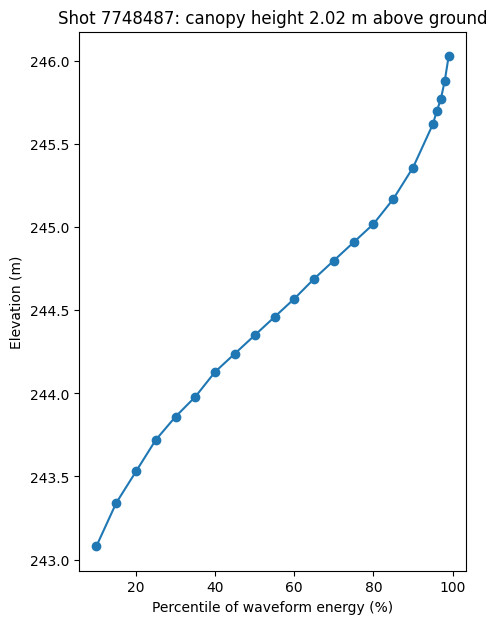

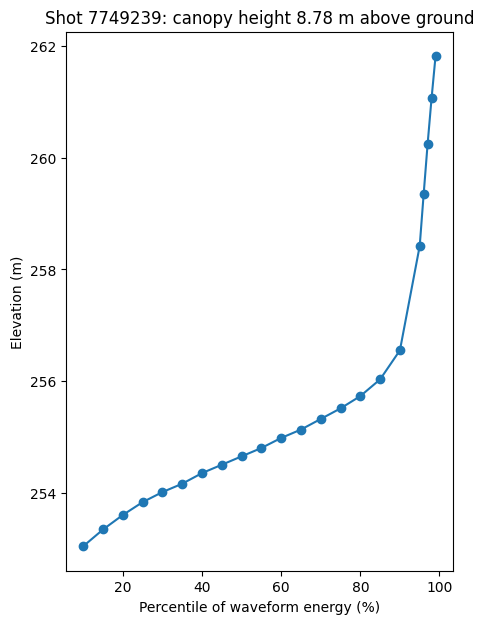

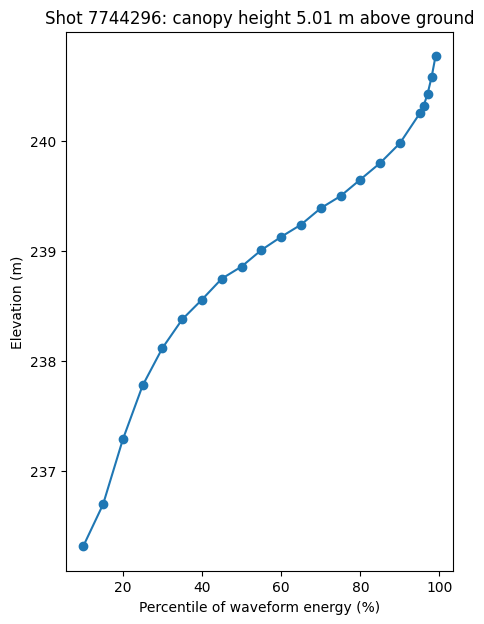

In [53]:
# plot canopy shape for the shot_number footprints
shot_list = [7748487, 7749239, 7744296]  # shot numbers
for s in shot_list:
    plot_canopy_shape(l2a_df, s, shot_col='SHOTNUMBER')

The first and third shot likely represent a shrub, and shot two is the one most likely to be the silvertree given the height and crown height returns. Will still have to verify though. Also, I cannot show the 3D structure of the trees, so I have no clue wagwan.